# Importing Dependencies

In [439]:
# Importing Numpy library
import numpy as np

# Importing Pandas library
import pandas as pd

# Importing plotying libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Prophet library
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Importing Scikit-learn libraries
from sklearn.linear_model import LinearRegression

# Importing Statsmodels library
from statsmodels.stats.diagnostic import acorr_ljungbox

# Importing Scipy Stats
from scipy import stats

# 1. Generalized Additive Models (GAMs)

A business time series exhibits trend, seasonality, and holiday effects. It is well characterized by GAMs, which consider a time series to consist of three components: a linear trend, a seasonal effect, and any holiday effect. GAMs were originally invented by Trevor Hastie and Robert Tibshirani in 1986 [1]. The idea of GAMs is intuitive:

- Relationships between the individual predictors and the dependent variable follow smooth patterns that can be linear or nonlinear.
- Additive: these smooth relationships can be estimated simultaneously and then added up.

GAMs have the following components:

$$
Y(t) = T(t) + S(t) + H(t) + \epsilon (t)
$$

- $T(t)$: Trend;
- $S(t)$: Seasonality for weekly, monthly, and yearly seasonality;
- $H(t)$: Holiday Effects for the effects of holidays that occur on potentially irregular schedules over one or more days;
- $\epsilon (t)$ is for any idiosyncratic changes that are not accommodated by the model. This often interpreted as the error term and in most cases it is assumed to follow a normal distribution;

## 1.1. GAMs with Prophet

Prophet is an open-source library for time series by Facebook. Prophet is widely used because it is intuitive, easy to use, and has great visualization tools. Data scientists and engineers who need to build forecasting models quickly will find it very helpful.

The `daily-website-visitors` dataset is about the number of visitors to an academic teaching notes website from Kaggle.com. This dataset has daily counts of page loads, unique visitors, first-time visitors, and returning visitors. The dataset covers the date range from September 14, 2014, to August 19, 2020.

### 1.1.1. Data Processing

In [440]:
# Defining local path to dataset
path = '../data/{dataset_name}'

# Reading dataset
df = pd.read_csv(path.format(dataset_name="daily-website-visitors.csv"), thousands=',')

# Printing first 3 rows
df.head(3)

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278


**Prophet is a tool for univariate time series**. It requires two columns with the names ds and y.

In [441]:
# Convert string to datetime64
df["Date"] = pd.to_datetime(df["Date"])

# Selecting only the columns we need
df = df[['First.Time.Visits', 'Date']]

# Renaming columns         
df.columns = ['y', 'ds']
              
# Converting the number of first time visits to numeric
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# Selecting only data after 2017
df = df[df['ds'] >= pd.to_datetime('2017-01-01')]

# Sorting by date
df = df.sort_values(by='ds').reset_index(drop=True)
                    
# Printing first 3 rows
df.head(3)

,y,ds
0,832,2017-01-01
1,1448,2017-01-02
2,1970,2017-01-03


The chart below illustrates the time series of first-time visitors to the website. Overall, the data reveals that visitor numbers typically peak around April and November, with the lowest points occurring in January and July. However, an exception is observed in November 2017, where no peak in visits is evident, and to a lesser extent, in April 2017, where the peak is notably smaller if compared to other years.

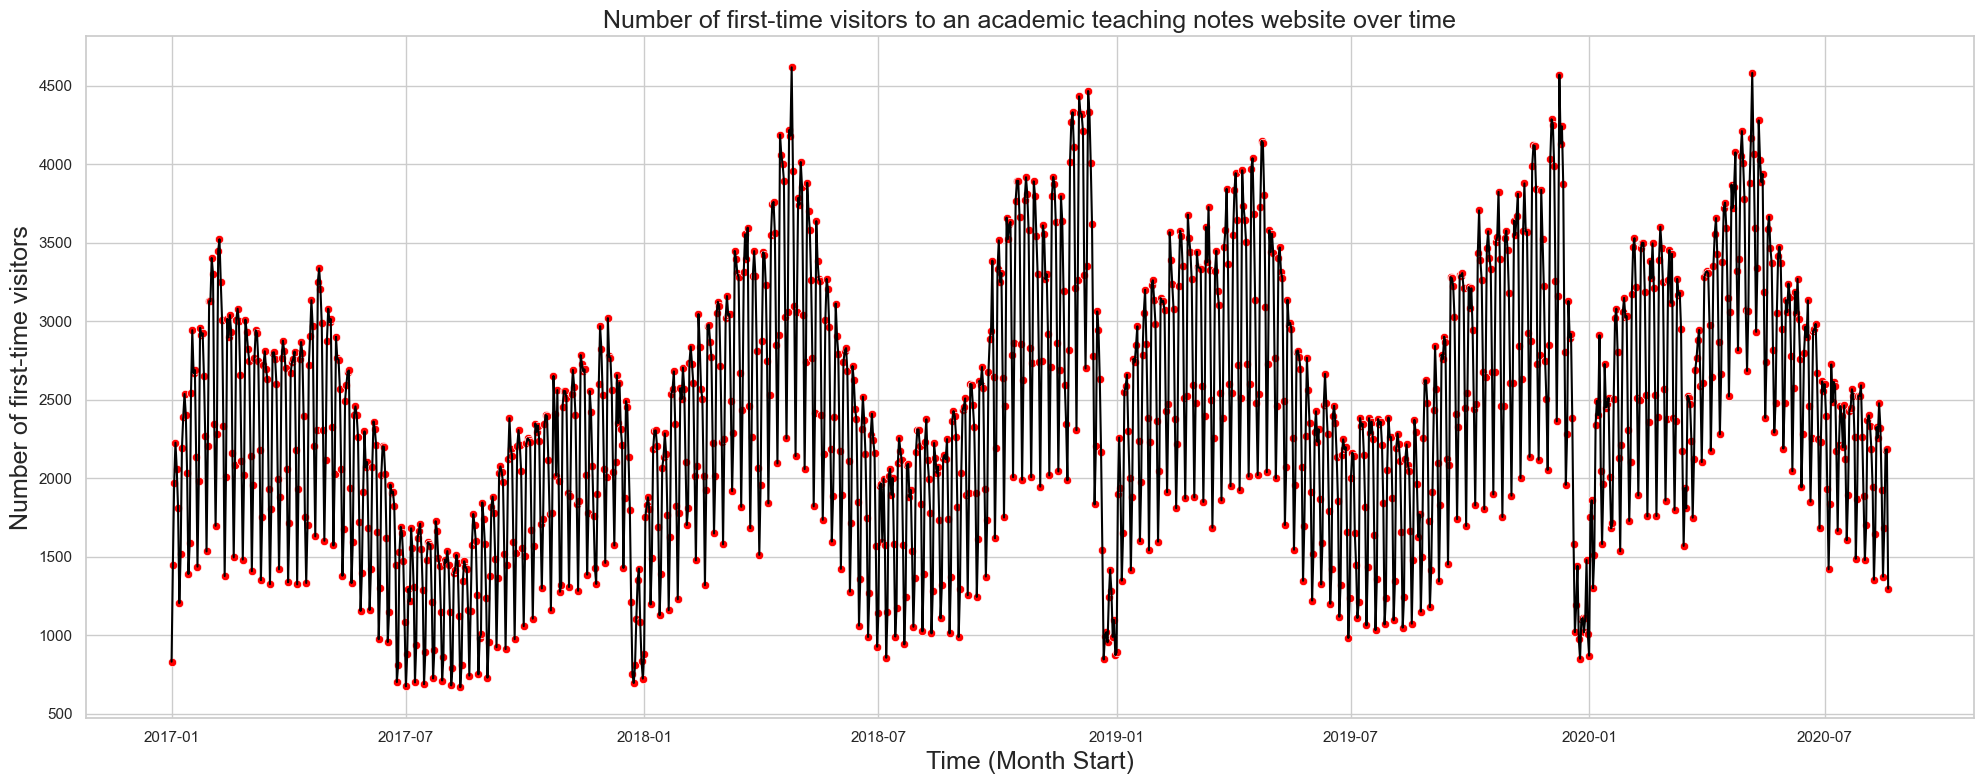

In [442]:
# Set the figure size
plt.figure(figsize=(20, 8))

###################################################################################
#plt.subplot(211)
sns.set(style="whitegrid")
sns.scatterplot(data=df, x="ds", y="y", color="red")
sns.lineplot(data=df, x="ds", y="y", color="black")
plt.xlabel('Time (Month Start)', fontsize=18)
plt.ylabel('Number of first-time visitors', fontsize=18)
plt.title('Number of first-time visitors to an academic teaching notes website over time', fontsize=18)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

Time series modeling typically uses in-time (training set) and out-of-time (test set) data for model training and testing to build a model. The parameters of the model is estimated using the in-time data and the model is then evaluated using the out-of-time data. Since the data has a time structure, we cannot randomly split the dataset. Instead, we define a cutoff date and set the data prior to the cutoff date as the in-time data (training set) and the data after the cutoff date as the out-of-time data (test set).
For the puporse of the exercise, **the cutoff date will be set to 2020–02–01**.


In [443]:
# Training data
tr_df = df[df['ds'] <= pd.to_datetime('2020-02-01')]

# Testing data
tt_df = df[df['ds']  > pd.to_datetime('2020-02-01')]

### 1.1.2. Step-by-Step Time Series Analysis

The standard steps in time series analysis involve identifying the trend, seasonal, and error components. While there are various methods to accomplish this, a simple approach is as follows:

- **Trend Identification:** Fit a linear model to the series to determine the trend, then remove the trend from the series.
- **Seasonal Component Identification:** Identify seasonal patterns by averaging the values for each month and/or week in the detrended series. Remove the seasonal component from the series afterward.
- **Residual Analysis:** Analyze the residuals, which represent what remains after removing the trend and seasonal components. Ideally, the residuals should follow a normal distribution with a mean of zero and exhibit no autocorrelation (commonly referred to as white noise).

Next, additional features are engineered to simplify and enhance the calculation of the trend and seasonal components.

In [444]:
# Creating a support dataframe for training
trts_df = (

    # Referencing the training data
    tr_df

    # Creating the columns: day of the week, month number and the x value (time indicator)
    .assign(
        weekday = lambda x: x.ds.dt.day_of_week,
        month = lambda x: x.ds.dt.month,
        x = lambda x: x.index + 1
    )

    # Creating higher order terms for x to facilitate fitting the model
    .assign(
        x2 = lambda x: x.x ** 2,
        x3 = lambda x: x.x ** 3
    )
)

# Printing first 3 rows
trts_df.head(3)

,y,ds,weekday,month,x,x2,x3
0,832,2017-01-01,6,1,1,1,1
1,1448,2017-01-02,0,1,2,4,8
2,1970,2017-01-03,1,1,3,9,27


In [445]:
# Creating a support dataframe for testing
ttts_df = (

    # Referencing the testing data
    tt_df

    # Creating the columns: day of the week, month number and the x value (time indicator)
    .assign(
        weekday = lambda x: x.ds.dt.day_of_week,
        month = lambda x: x.ds.dt.month,
        x = lambda x: x.index + 1
    )

    # Creating higher order terms for x to facilitate fitting the model
    .assign(
        x2 = lambda x: x.x ** 2,
        x3 = lambda x: x.x ** 3
    )
)

# Printing first 3 rows
ttts_df.head(3)

,y,ds,weekday,month,x,x2,x3
1127,2106,2020-02-02,6,2,1128,1272384,1435249152
1128,3174,2020-02-03,0,2,1129,1274641,1439069689
1129,3472,2020-02-04,1,2,1130,1276900,1442897000


#### 1.1.2.1. Removing Trend

Analyzing the results obtained from the linear models below, we observe that the first-order model produces the lowest error, as measured by the Root Mean Square Error (RMSE). Consequently, the detrending process is carried out using the first-order model. Detrending involves removing the trend (or level) from the y-values of the time series. This process results in a time series that ideally retains only the seasonal and error components.

Additionally, we observe that the coefficient of the first-order term in $x$ is positive, indicating a slight increase in the average number of first-time visitors to the website over time.

In [446]:
# Fitting a first order linear model to the training
lr_1o = LinearRegression(fit_intercept=True).fit(trts_df[['x']], trts_df['y'])

# Calculating the predictions for the first order linear model
y_pred_1o = lr_1o.predict(ttts_df[['x']])

# Calculating the root mean squared error for the first order linear model
rmse_1o = np.mean((y_pred_1o - ttts_df.y) ** 2 ) ** 0.5

# Printing the result
print(f"RMSE (1st order linear model): {rmse_1o}")
print(f"Linear Model Components: {lr_1o.coef_[0]:.2f} * x + {lr_1o.intercept_:.2f}")

RMSE (1st order linear model): 699.9060700214222
Linear Model Components: 0.60 * x + 1996.50


In [447]:
# Fitting a first order linear model to the training
lr_2o = LinearRegression(fit_intercept=True).fit(trts_df[['x', 'x2']], trts_df['y'])

# Calculating the predictions for the first order linear model
y_pred_2o = lr_2o.predict(ttts_df[['x', 'x2']])

# Calculating the root mean squared error for the first order linear model
rmse_2o = np.mean((y_pred_2o - ttts_df.y) ** 2 ) ** 0.5

# Printing the result
print(f"RMSE (2nd order linear model): {rmse_2o}")
print(f"Linear Model Components: {lr_2o.coef_[0]:.2f} * x + {lr_2o.coef_[1]:.2f} * x^2 + {lr_2o.intercept_:.2f}")

RMSE (2nd order linear model): 704.4604497937404
Linear Model Components: 1.02 * x + -0.00 * x^2 + 1916.62


In [448]:
# Fitting a first order linear model to the training
lr_3o = LinearRegression(fit_intercept=True).fit(trts_df[['x', 'x2', 'x3']], trts_df['y'])

# Calculating the predictions for the first order linear model
y_pred_3o = lr_3o.predict(ttts_df[['x', 'x2', 'x3']])

# Calculating the root mean squared error for the first order linear model
rmse_3o = np.mean((y_pred_3o - ttts_df.y) ** 2 ) ** 0.5

# Printing the result
print(f"RMSE (3rd order linear model): {rmse_3o}")
print(f"Linear Model Components: {lr_3o.coef_[0]:.2f} * x + {lr_3o.coef_[1]:.2f} * x^2 + {lr_3o.coef_[2]:.2f} * x^3 + {lr_3o.intercept_:.2f}")

RMSE (3rd order linear model): 1241.7199985267246
Linear Model Components: -3.05 * x + 0.01 * x^2 + -0.00 * x^3 + 2300.02


In [449]:
# Removing the trend from the training data
trts_df['y_detrended'] = trts_df['y'] - lr_1o.predict(trts_df[['x']])

# Removing the trend from the testing data
ttts_df['y_detrended'] = ttts_df['y'] - lr_1o.predict(ttts_df[['x']])

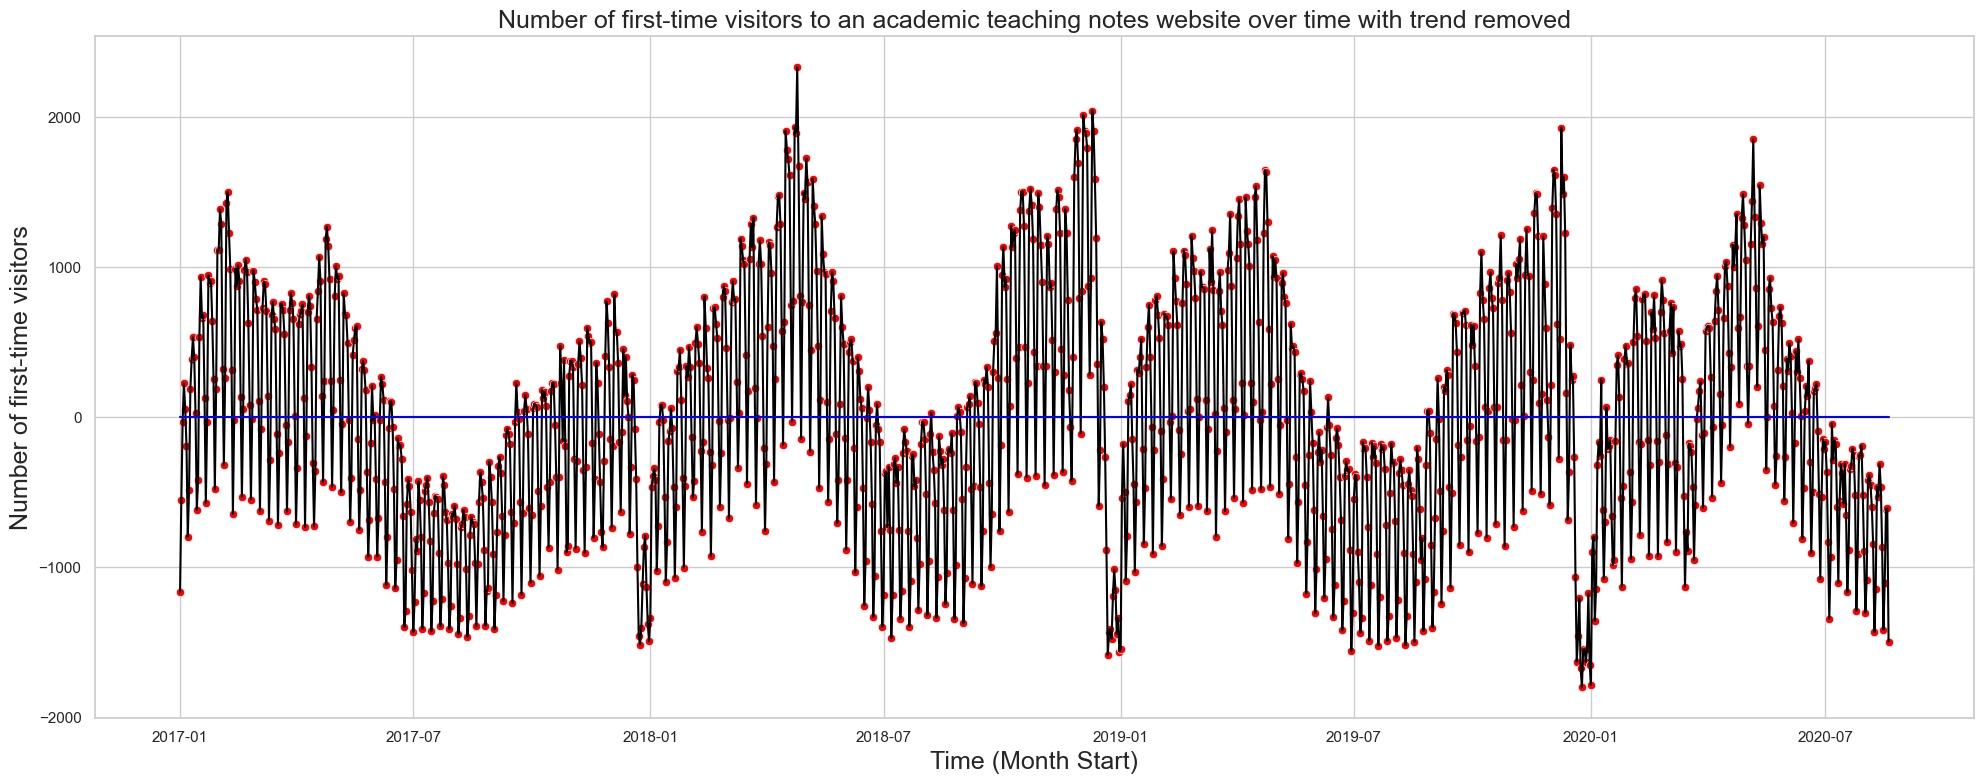

In [450]:
# Set the figure size
plt.figure(figsize=(20, 8))

###################################################################################
#plt.subplot(211)
sns.set(style="whitegrid")
sns.scatterplot(
    x=np.concatenate([trts_df.ds.values, ttts_df.ds.values], axis=0), 
    y=np.concatenate([trts_df.y_detrended.values, ttts_df.y_detrended.values], axis=0), 
    color="red"
)
sns.lineplot(
    x=np.concatenate([trts_df.ds.values, ttts_df.ds.values], axis=0), 
    y=np.concatenate([trts_df.y_detrended.values, ttts_df.y_detrended.values], axis=0), 
    color="black"
)
sns.lineplot(
    x=[trts_df.ds.values[0], ttts_df.ds.values[-1]],
    y=[0, 0],
    color="blue"
)
plt.xlabel('Time (Month Start)', fontsize=18)
plt.ylabel('Number of first-time visitors', fontsize=18)
plt.title('Number of first-time visitors to an academic teaching notes website over time with trend removed', fontsize=18)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

#### 1.1.2.2. Removing Seasonal Components

Seasonal components are cyclical patterns that account for part or even most of the non-random fluctuations in a time series. The final seasonality may arise from a single cyclical signal or a combination of multiple signals.

In the case under study, it is hypothesized that visits to the website are seasonal, influenced by two distinct signals:

- **Weekly Seasonality**: A high-frequency, low-amplitude signal (resulting in lower variance) with 52 oscillations per year.
- **Monthly Seasonality**: A low-frequency, high-amplitude signal (resulting in higher variance) with 12 oscillations per year.

Given the assumption that the monthly signal has higher variance, this signal will be estimated first. Afterward, the monthly seasonality will be removed from the detrended series, allowing the weekly seasonality to be estimated from the remaining data.

In [451]:
# Calculating monthly averages (seasonality)
monthly_seasonality_df = (

    # Referencing the detrended data
    trts_df

    # Creating a column to denote the year
    .assign(year = lambda x: x.ds.dt.year)

    # Grouping by year and month: this process is necessary to smooth daily fluctuations within the same month
    # Daily fluctuations within a month should be captured by the weekly seasonality
    .groupby(['year', 'month'])
    .agg({
        'y_detrended':'mean'
    })
    .reset_index()

    # Calculating the monthly average and standard deviation
    .assign(
        month_mu = lambda x: x.y_detrended,
        month_sd = lambda x: x.y_detrended
    )
    .groupby(['month'])
    .agg({
        'month_mu':'mean',
        'month_sd':'std'
    })
    .reset_index()
)

# Printing the result
monthly_seasonality_df

,month,month_mu,month_sd
0,1,-146.757422,251.008829
1,2,46.239805,680.658850
2,3,393.221823,78.500908
3,4,684.202049,331.395398
4,5,275.226002,291.909703
5,6,-450.564024,170.053677
6,7,-712.780572,117.951082
7,8,-676.658759,187.127517
8,9,-248.807207,217.419940
9,10,336.506710,487.635657


In [452]:
# Adding the monthly seasonality to the training and testing data
trts_df = trts_df.merge(monthly_seasonality_df[['month', 'month_mu']], on='month', how='left')
ttts_df = ttts_df.merge(monthly_seasonality_df[['month', 'month_mu']], on='month', how='left')

# Removing the monthly seasonality from the training and testting data
trts_df['y_detrended_monthly'] = trts_df['y_detrended'] - trts_df['month_mu']
ttts_df['y_detrended_monthly'] = ttts_df['y_detrended'] - ttts_df['month_mu']

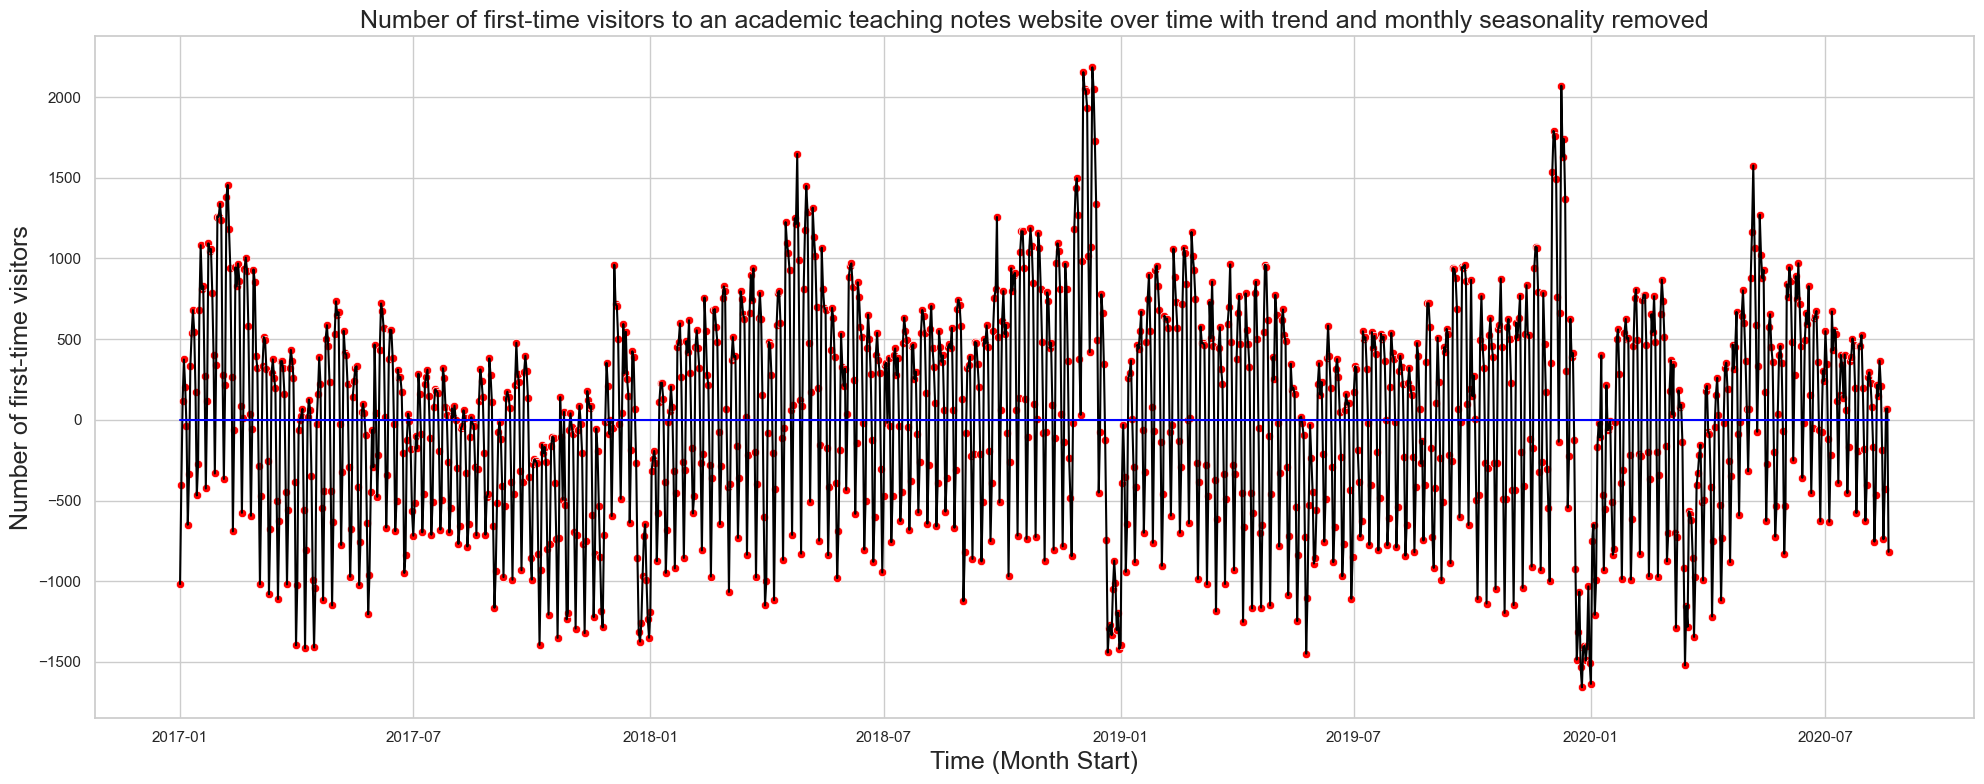

In [453]:
# Set the figure size
plt.figure(figsize=(20, 8))

###################################################################################
#plt.subplot(211)
sns.set(style="whitegrid")
sns.scatterplot(
    x=np.concatenate([trts_df.ds.values, ttts_df.ds.values], axis=0), 
    y=np.concatenate([trts_df.y_detrended_monthly.values, ttts_df.y_detrended_monthly.values], axis=0), 
    color="red"
)
sns.lineplot(
    x=np.concatenate([trts_df.ds.values, ttts_df.ds.values], axis=0), 
    y=np.concatenate([trts_df.y_detrended_monthly.values, ttts_df.y_detrended_monthly.values], axis=0), 
    color="black"
)
sns.lineplot(
    x=[trts_df.ds.values[0], ttts_df.ds.values[-1]],
    y=[0, 0],
    color="blue"
)
plt.xlabel('Time (Month Start)', fontsize=18)
plt.ylabel('Number of first-time visitors', fontsize=18)
plt.title('Number of first-time visitors to an academic teaching notes website over time with trend and monthly seasonality removed', fontsize=18)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

In [454]:
# Calculating weekday averages (seasonality)
weekly_seasonality_df = (
    trts_df
    .assign(
        weekday_mu = lambda x: x.y_detrended_monthly,
        weekday_sd = lambda x: x.y_detrended_monthly
    )
    .groupby(['weekday'])
    .agg({
        'weekday_mu':'mean',
        'weekday_sd':'std'
    })
    .reset_index()
)

# Printing the result
weekly_seasonality_df

,weekday,weekday_mu,weekday_sd
0,0,424.893157,565.012582
1,1,492.961444,531.180610
2,2,454.715191,515.708568
3,3,331.461975,453.070467
4,4,-224.675868,351.600420
5,5,-876.402569,288.544953
6,6,-436.910274,392.450169


In [455]:
# Adding the weekday seasonality to the training and testing data
trts_df = trts_df.merge(weekly_seasonality_df[['weekday', 'weekday_mu']], on='weekday', how='left')
ttts_df = ttts_df.merge(weekly_seasonality_df[['weekday', 'weekday_mu']], on='weekday', how='left')

# Removing the weekly seasonality from the training and testting data
trts_df['residual'] = trts_df['y_detrended_monthly'] - trts_df['weekday_mu']
ttts_df['residual'] = ttts_df['y_detrended_monthly'] - ttts_df['weekday_mu']

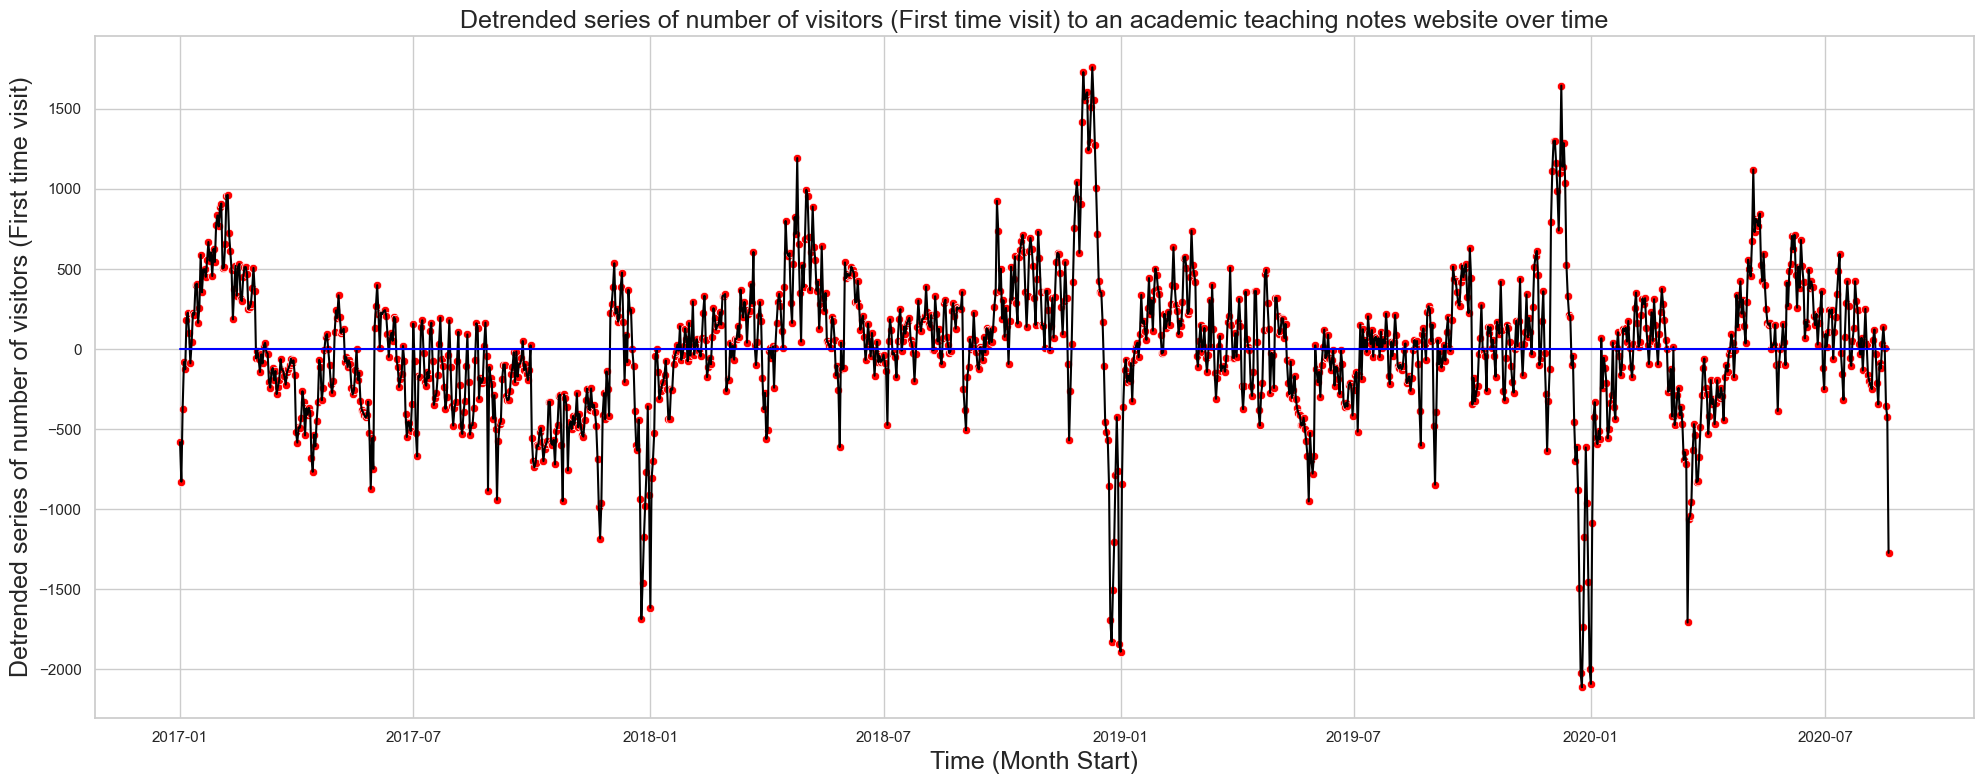

In [456]:
# Set the figure size
plt.figure(figsize=(20, 8))

###################################################################################
#plt.subplot(211)
sns.set(style="whitegrid")
sns.scatterplot(
    x=np.concatenate([trts_df.ds.values, ttts_df.ds.values], axis=0), 
    y=np.concatenate([trts_df.residual.values, ttts_df.residual.values], axis=0), 
    color="red"
)
sns.lineplot(
    x=np.concatenate([trts_df.ds.values, ttts_df.ds.values], axis=0), 
    y=np.concatenate([trts_df.residual.values, ttts_df.residual.values], axis=0), 
    color="black"
)
sns.lineplot(
    x=[trts_df.ds.values[0], ttts_df.ds.values[-1]],
    y=[0, 0],
    color="blue"
)
plt.xlabel('Time (Month Start)', fontsize=18)
plt.ylabel('Detrended series of number of visitors (First time visit)', fontsize=18)
plt.title('Detrended series of number of visitors (First time visit) to an academic teaching notes website over time', fontsize=18)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

#### 1.1.2.3. Residual Analysis

As previously mentioned, the residuals of a time series (i.e., the remaining component after removing trend and seasonality) should typically be normally distributed around zero and exhibit no autocorrelation. This ensures that the residuals behave as closely as possible to random noise, also referred to as white noise.

If the residuals are not centered around zero, it suggests that some information has not been captured by the trend function (should have been incorporated in the intercept). Similarly, if autocorrelation is present, it indicates that the model failed to account for certain patterns, which could be related to the trend function (via slope coefficients) or the seasonality terms. In such cases, it is recommended to revisit the modeling process and experiment with different functions for trend and/or seasonality.

To verify that the residuals are free from autocorrelation, it is advisable to perform a statistical test such as the Ljung-Box test.

**The Ljung-Box Test**

The Ljung-Box test is a statistical method used to assess whether significant autocorrelation exists in a time series after fitting a model. It evaluates the null hypothesis that a series of residuals is independently distributed, meaning there is no autocorrelation.

**Test Setup**

- **Null Hypothesis ($H_0$)**: The data (or residuals) are independently distributed (no significant autocorrelation).
- **Alternative Hypothesis ($H_1$)**: The data (or residuals) exhibit autocorrelation.
- **Test Statistic**: The test calculates a statistic based on the autocorrelations of the residuals up to a certain lag m.
- **p-value**: If the p-value is small (typically < 0.05), the null hypothesis is rejected, indicating the presence of autocorrelation.

Observation: Since the model was trained using the training data only, the residual analysis should also be performed exclusively on the training data. This is because the test data may contain new information that was not available during the training process, potentially introducing factors that could interfere with the analysis.

In [457]:
# Extracting the residuals
normalized_residuals = trts_df.residual.values / np.std(trts_df.residual.values)

# Sorting the residuals and calculating the CDF
normalized_residuals_sorted = np.sort(normalized_residuals)
normalized_residuals_cdf = np.arange(1, normalized_residuals.shape[0]+1, 1) / normalized_residuals.shape[0]

# Sampling from a standard normal distribution
standard_normal_distribution_sorted = np.sort(np.random.normal(loc=0, scale=1, size=normalized_residuals.shape[0]))

# Printing the center and spread of the residuals
print(f"Residuals Center: {np.mean(normalized_residuals):.2f}")
print(f"Residuals Spread: {np.std(normalized_residuals):.2f}")

Residuals Center: 0.00
Residuals Spread: 1.00


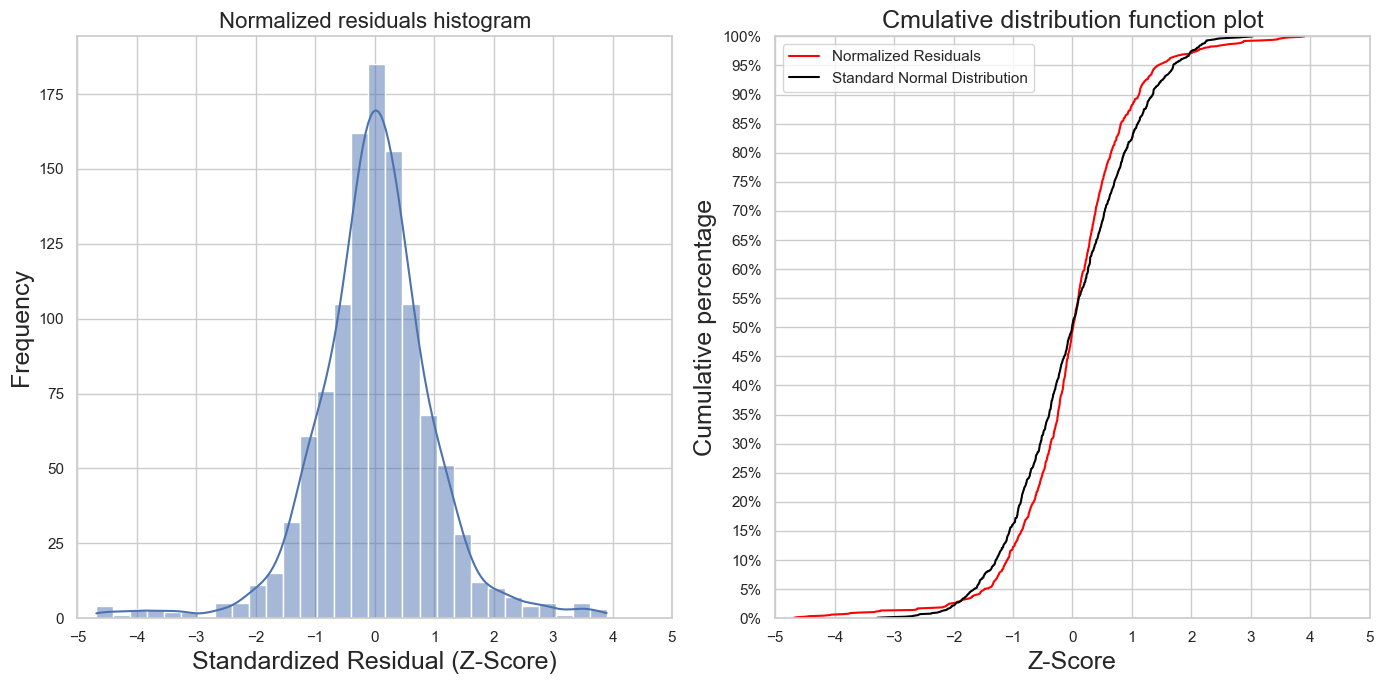

In [458]:
# Set the figure size
plt.figure(figsize=(14, 7))

###################################################################################
plt.subplot(121)
sns.set(style="whitegrid")

# Create a histogram of the 'y' column
sns.histplot(normalized_residuals, bins=30, kde=True)

# Set the labels and title
plt.xlabel('Standardized Residual (Z-Score)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Normalized residuals histogram', fontsize=16)

plt.xlim([-5, 5])
plt.xticks(ticks=[-5 + i*1 for i in range(11)])

###################################################################################
plt.subplot(122)
sns.set(style="whitegrid")
sns.lineplot(
    x=normalized_residuals_sorted, 
    y=normalized_residuals_cdf, 
    color="red",
    label="Normalized Residuals"
)
sns.lineplot(
    x=standard_normal_distribution_sorted, 
    y=normalized_residuals_cdf, 
    color="black",
    label="Standard Normal Distribution"
)
plt.xlabel('Z-Score', fontsize=18)
plt.ylabel('Cumulative percentage', fontsize=18)
plt.title('Cmulative distribution function plot', fontsize=18)

plt.xlim([-5, 5])
plt.xticks(ticks=[-5 + i*1 for i in range(11)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

In [459]:
# Perform the Ljung-Box test
ljung_box_result = acorr_ljungbox(trts_df['residual'], lags=[10], return_df=True)

# Print the result
print(ljung_box_result)

        lb_stat  lb_pvalue
10  4168.867966        0.0


By examining the cumulative distribution function of the residuals, it becomes evident that while the residuals are centered around zero, they exhibit heavier tails compared to a normal distribution and, therefore, could not be considered as a normal distribution.

Additionally, the results of the Ljung-Box test indicate that the null hypothesis of no autocorrelation is rejected, which indicates that there are statistical evidence of auto-correlation in the residual. As a result, it would be prudent to explore Auto-Regressive (AR) models to better capture the autocorrelation present in the residuals.

Finally, regarding prediction accuracy, the RMSE and MAPE metrics for the forecast are 397 visits and 11.66%, respectively. These results are reasonable, considering this was a straightforward initial implementation of an Additive Time Series Model (Trend + Seasonality + Error). Possible next steps for improvement could be: explore Auto-Regressive (AR) models, consider the impact of holidays, model seasonality using alternative functions like sine and consine.

In [460]:
# Calculating the prediction for the testing data
ttts_df['y_pred'] = lr_1o.predict(ttts_df[['x']]) + ttts_df['month_mu'] + ttts_df['weekday_mu']

# Calculating RMSE for the model
rmse = np.mean((ttts_df['y_pred'] - ttts_df['y']) ** 2) ** 0.5

# Calculating MAPE for the model
mape = np.mean(np.abs(ttts_df['y_pred'] - ttts_df['y']) / ttts_df['y']) * 100

# Printing the result
print(f"RMSE (Linear Model with Monthly and Weekly Seasonality): {rmse:.2f}")
print(f"MAPE (Linear Model with Monthly and Weekly Seasonality): {mape:.2f}%")

RMSE (Linear Model with Monthly and Weekly Seasonality): 397.42
MAPE (Linear Model with Monthly and Weekly Seasonality): 11.66%


#### 1.1.2.4. Forecasting

The visualization below compares the original time series (black) with the forecasted values (red). It is evident that the forecast overestimates the number of visits during part of March 2020 and underestimates the number of visits in June 2020. A possible explanation for these discrepancies could be external factors, as the patterns observed in 2020 differ from those seen in 2018 and 2019.

One plausible explanation is the onset of the COVID-19 pandemic in March 2020, which may have disrupted class schedules. This is reflected in the sudden decrease in visitor numbers at the beginning of March, followed by a gradual recovery in the subsequent days and a possible delay on the postponement of the end of classes in July to allow for the completion of the required course hours, which may have resulted in an unusually high volume of visits during June and July.

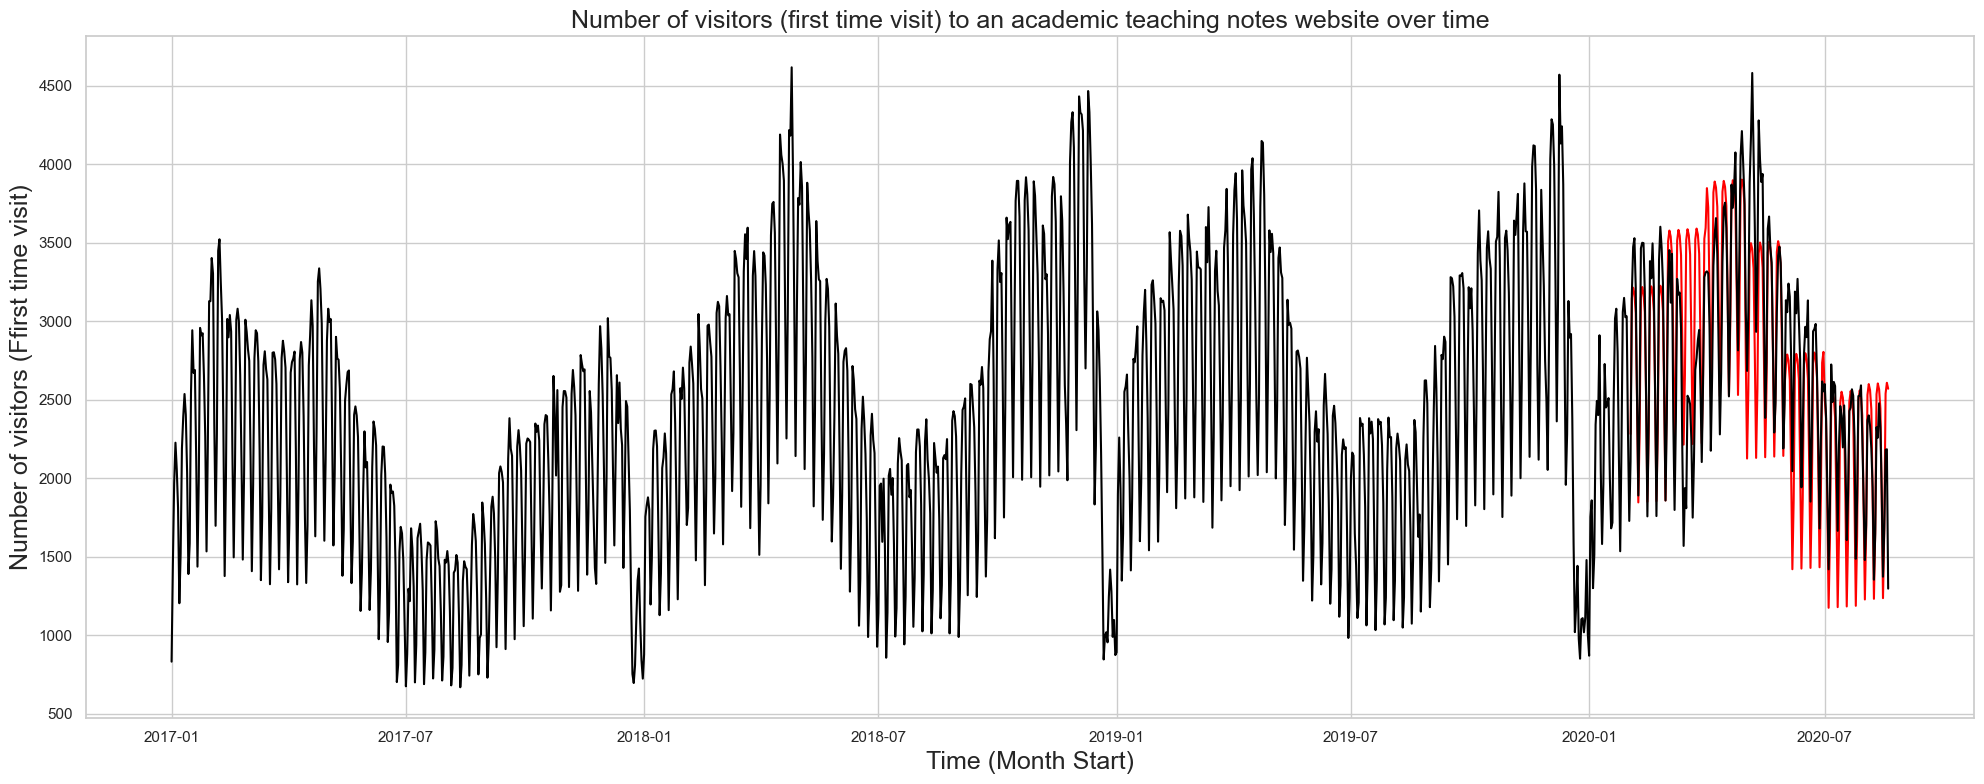

In [461]:
# Set the figure size
plt.figure(figsize=(20, 8))

###################################################################################
#plt.subplot(211)
sns.set(style="whitegrid")
sns.lineplot(data=ttts_df, x="ds", y="y_pred", color="red")
sns.lineplot(data=df, x="ds", y="y", color="black")
plt.xlabel('Time (Month Start)', fontsize=18)
plt.ylabel('Number of visitors (Ffirst time visit)', fontsize=18)
plt.title('Number of visitors (first time visit) to an academic teaching notes website over time', fontsize=18)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

### 1.1.2. Fitting the data to a Prophet model

In [462]:
# Creating a Prophet model object
m = Prophet()

# Adding US holidays
m.add_country_holidays(country_name='US')

# Fit: Fitting with default parameters
m.fit(tr_df)

# Future: Generate data points for the future period
future= m.make_future_dataframe(periods=tt_df.shape[0], freq='d')

# Show the last 5 rows of the future dataframe                                
future.tail()

10:19:39 - cmdstanpy - INFO - Chain [1] start processing
10:19:39 - cmdstanpy - INFO - Chain [1] done processing


,ds
1322,2020-08-15
1323,2020-08-16
1324,2020-08-17
1325,2020-08-18
1326,2020-08-19


In [463]:
# Forecast: Apply the model to forecast the future data points
forecast=m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1322,2020-08-15,2520.448667,529.333203,1260.569970,2305.002573,2696.128572,0.0,0.0,0.0,0.0,...,-919.178791,-919.178791,-919.178791,-685.001872,-685.001872,-685.001872,0.0,0.0,0.0,916.268005
1323,2020-08-16,2520.360098,953.763599,1733.153800,2302.817650,2697.742054,0.0,0.0,0.0,0.0,...,-469.819035,-469.819035,-469.819035,-677.544571,-677.544571,-677.544571,0.0,0.0,0.0,1372.996491
1324,2020-08-17,2520.271528,1881.634628,2623.588931,2299.581770,2698.742966,0.0,0.0,0.0,0.0,...,425.117208,425.117208,425.117208,-670.074228,-670.074228,-670.074228,0.0,0.0,0.0,2275.314508
1325,2020-08-18,2520.182959,1948.866919,2680.723090,2297.617305,2699.886858,0.0,0.0,0.0,0.0,...,472.940813,472.940813,472.940813,-662.613406,-662.613406,-662.613406,0.0,0.0,0.0,2330.510366
1326,2020-08-19,2520.094389,1909.135782,2684.143826,2296.045150,2700.947502,0.0,0.0,0.0,0.0,...,435.699464,435.699464,435.699464,-655.154461,-655.154461,-655.154461,0.0,0.0,0.0,2300.639393


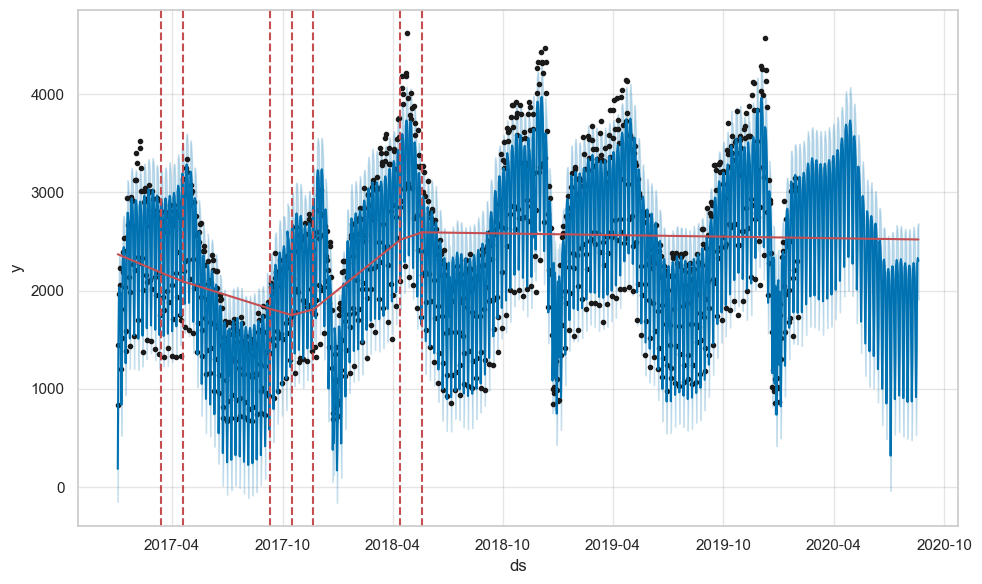

In [464]:
# Visualizong the forecast using the Prophet changepoints plot
# A change point in a time series refers to a point in time at which the statistical properties of the series, such as the mean, variance, or autocorrelation, change significantly.
fig= m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Plotting model components:
- Trend;
- Holidays;
- Weekly seasonality;
- Yearly seasonality;

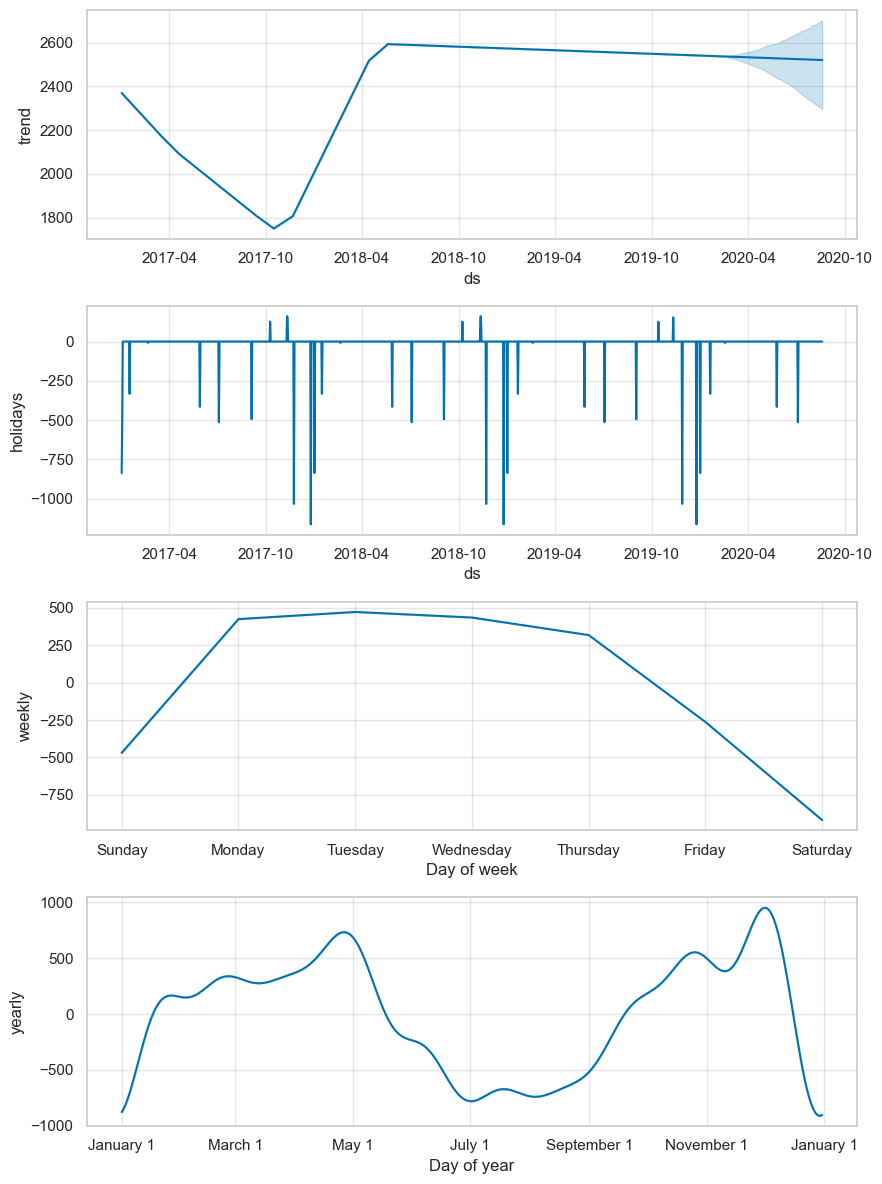

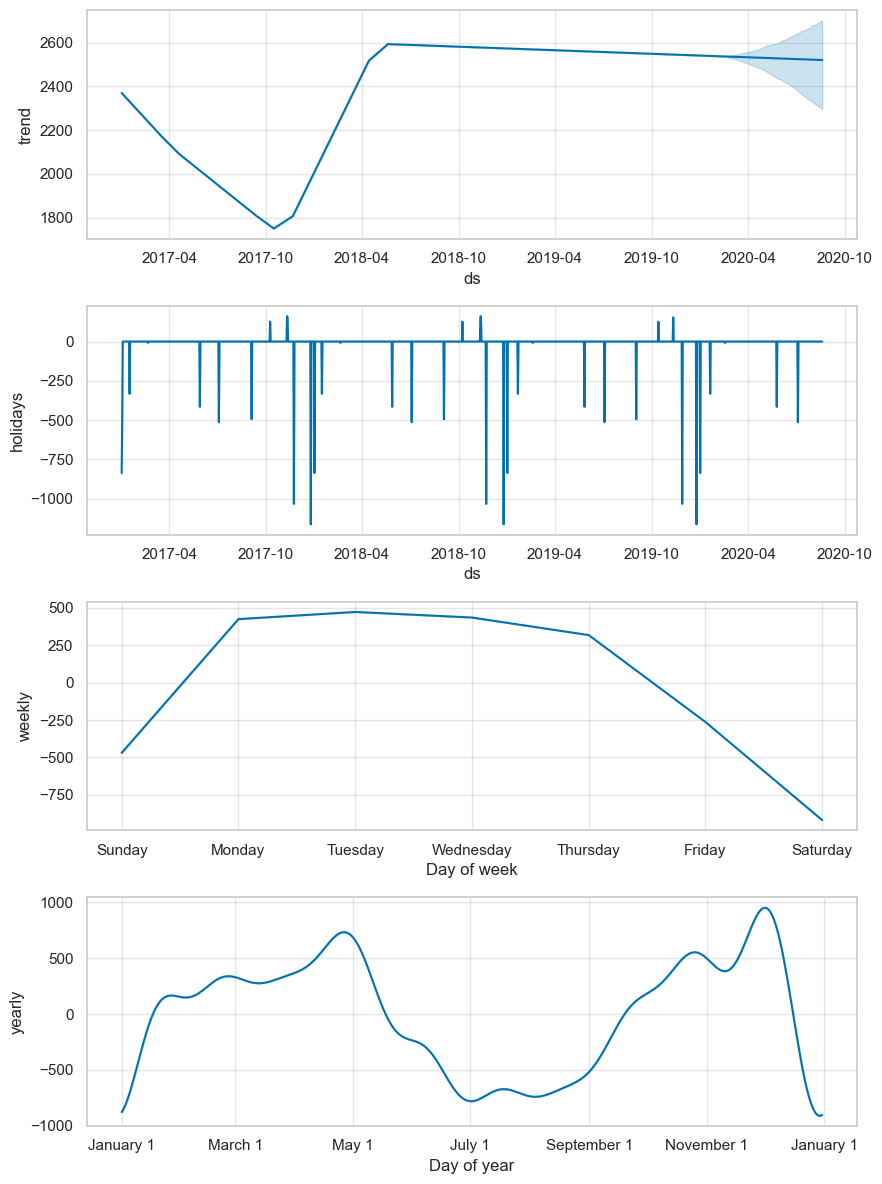

In [465]:
m.plot_components(forecast)

In [1]:
# Text

In [2]:
1+1

2